# Sensitivity analysis of critical head difference

In this example, we demonstrate how to perform a sensitivity analysis. The purpose of a sensitivity analysis is to determine how the model output responds to variations in the input parameters.

We use the critical head difference model according to Sellmeijer. This model applies to the piping failure mechanism, which describes backward internal erosion beneath dikes with predominantly horizontal seepage paths.

### Define model

First, let's import the necessary packages:

In [90]:
from probabilistic_library import SensitivityProject, DistributionType, SensitivityMethod

The critical head difference, $H_c$, according to the Sellmeijer's model is described by the following equations:

$F_{resistance}=\eta\cdot \frac{\gamma_{sub,particles}}{\gamma_{water}}\cdot \tan \theta_{sellmeijer,rev}$


$F_{scale}=\frac{d_{70.m}}{\sqrt[3]{\kappa\cdot L}}\cdot\left(\frac{d_{70}}{d_{70.m}}\right)^{0.4}$ and $\kappa = \frac{\nu_{water}}{g}\cdot k$


$F_{geometry}=0.91\cdot \left(\frac{D}{L}\right)^{\frac{0.28}{\left(\frac{D}{L}\right)^{2.8}-1}+0.04}$

$H_c = F_{resistance} \cdot F_{scale} \cdot F_{geometry} \cdot L$

where: <br>
$L$ - seepage length (m) <br>
$D$ - thickness of upper sand layer (m) <br>
$\theta$ - bedding angle ($\circ$) <br>
$d_{70}$ - particle diameter (m) <br>
$k$ - permeability of the upper sand layer (m/s)

In [91]:
from utils.models import model_sellmeijer

### Sensitivity analysis

The goal is to estimate the effect of the input parameters $k$, $L$, $d_{70}$, and $D$ on the critical head difference.
To achieve this, we perform a sensitivity analysis. We begin by creating a sensitivity project and defining the model:

In [92]:
project = SensitivityProject()
project.model = model_sellmeijer

project.model.print()

Model model_sellmeijer:
Input parameters:
  k
  L
  d70
  D
Output parameters:
  delta_h_c


We define all the input parameters of the model as random variables:

In [93]:
def project_variables(project):

    project.variables["k"].distribution = DistributionType.log_normal
    project.variables["k"].mean = 0.000245598
    project.variables["k"].variation = 0.25

    project.variables["L"].distribution = DistributionType.log_normal
    project.variables["L"].mean = 40.0
    project.variables["L"].variation = 0.25

    project.variables["d70"].distribution = DistributionType.log_normal
    project.variables["d70"].mean = 0.00019
    project.variables["d70"].variation = 0.25

    project.variables["D"].distribution = DistributionType.log_normal
    project.variables["D"].mean = 30.0
    project.variables["D"].variation = 0.25

    return project

The sensitivity analysis can be performed using one of two methods: `single_variation` or `sobol`.

### Single variation

This method evaluates the effect of varying a single input variable on the model output while keeping all other variables fixed at their median values. It is a straightforward approach, typically used as an initial step before applying more advanced sensitivity analysis techniques.

The method produces `low`, `medium`, and `high` quantiles of the model output for each input parameter. The low and high quantiles can be specified by the user in the project settings as `low_value` and `high_value`, respectively. By default, these parameters are set to $0.05$ and $0.95$.

In [94]:
project_variables(project)
project.settings.sensitivity_method = SensitivityMethod.single_variation
project.settings.low_value = 0.01
project.settings.high_value = 0.99

project.run()

The results of the method are stored in `project.results[0].values`. The results can be printed and plotted.

Parameter: delta_h_c
Values:
  k: low = 2.796, medium = 2.31, high = 1.908
  L: low = 1.489, medium = 2.31, high = 3.726
  d70: low = 1.848, medium = 2.31, high = 2.888
  D: low = 2.543, medium = 2.31, high = 2.181


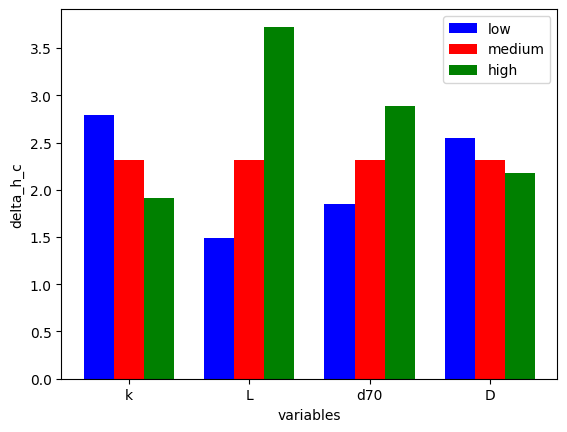

In [95]:
sens = project.results[0]
sens.print()
sens.plot()

Let's decrease the variation of the input parameter $L$ and perform the sensitivity analysis again:

Parameter: delta_h_c
Values:
  k: low = 2.854, medium = 2.358, high = 1.948
  L: low = 1.962, medium = 2.358, high = 2.852
  d70: low = 1.886, medium = 2.358, high = 2.948
  D: low = 2.599, medium = 2.358, high = 2.222


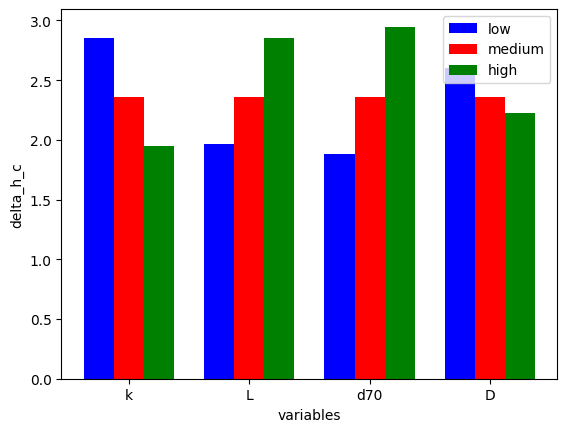

In [96]:
project.variables["L"].variation = 0.1

project.run()
sens = project.results[0]
sens.print()
sens.plot()

### Sobol indices

The Sobol method is a variance-based sensitivity analysis that decomposes the variance of the model output into fractions attributable to individual input parameters. The method produces a `first order index` and a `total index` for each input parameter. 

The `first order index` measures the effect of varying a single parameter on the output, averaged over variations in all other input parameters. The `total index` quantifies the contribution of a parameter to the output variance, including all variance arising from its interactions with other input variables.

Parameter: delta_h_c
Values:
  k: first order index = 0.1207, total index = 0.1224
  L: first order index = 0.6698, total index = 0.6999
  d70: first order index = 0.1592, total index = 0.1671
  D: first order index = 0.02125, total index = 0.02487


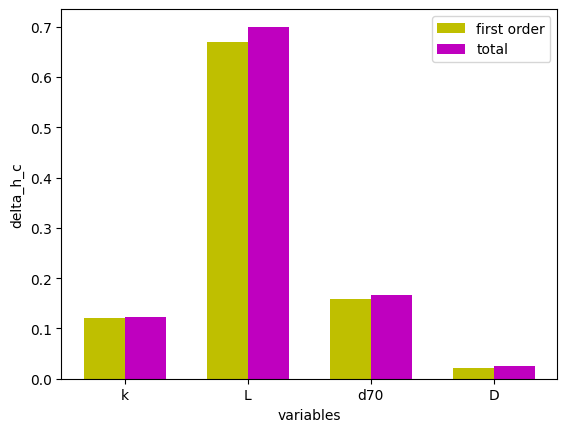

In [97]:
project = project_variables(project)
project.settings.sensitivity_method = SensitivityMethod.sobol

project.run()
sens = project.results[0]
sens.print()
sens.plot()

Let's decrease the variance of the parameter $L$ and recompute the Sobol indices:

Parameter: delta_h_c
Values:
  k: first order index = 0.2796, total index = 0.2888
  L: first order index = 0.2537, total index = 0.2754
  d70: first order index = 0.3816, total index = 0.394
  D: first order index = 0.0522, total index = 0.05352


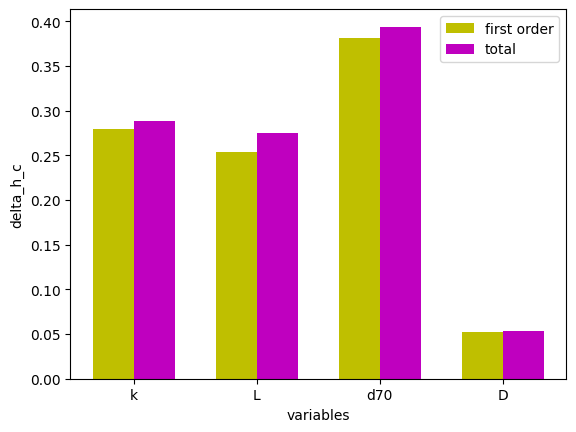

In [98]:
project.variables["L"].variation = 0.1

project.run()
sens = project.results[0]
sens.print()
sens.plot()